In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob

In [2]:
img_path=glob.glob("d:/datasets/20bigdata/*.jpg")

In [3]:
len(img_path)

3284

In [4]:
img_path[:5],img_path[-5:]

(['d:/datasets/20bigdata\\202031101020037-f-1.jpg',
  'd:/datasets/20bigdata\\202031101020037-f-10.jpg',
  'd:/datasets/20bigdata\\202031101020037-f-11.jpg',
  'd:/datasets/20bigdata\\202031101020037-f-12.jpg',
  'd:/datasets/20bigdata\\202031101020037-f-13.jpg'],
 ['d:/datasets/20bigdata\\202031113010290-m-6.jpg',
  'd:/datasets/20bigdata\\202031113010290-m-7.jpg',
  'd:/datasets/20bigdata\\202031113010290-m-8.jpg',
  'd:/datasets/20bigdata\\202031113010290-m-9.jpg',
  'd:/datasets/20bigdata\\\x7f202031101020041-m-8.jpg'])

In [5]:
import random
random.shuffle (img_path )

In [6]:
img_path[:5],img_path[-5:]

(['d:/datasets/20bigdata\\202031112050074-f-8.jpg',
  'd:/datasets/20bigdata\\202031112050047-m-2.jpg',
  'd:/datasets/20bigdata\\202031112050001-m-48.jpg',
  'd:/datasets/20bigdata\\202031112050024-m-11.jpg',
  'd:/datasets/20bigdata\\202031112050065肖梦恬-m-12.jpg'],
 ['d:/datasets/20bigdata\\202031112050097-f-9.jpg',
  'd:/datasets/20bigdata\\202031112050085-f-23.jpg',
  'd:/datasets/20bigdata\\202031112050011-m-12.jpg',
  'd:/datasets/20bigdata\\202031112050034-f-36.jpg',
  'd:/datasets/20bigdata\\202031112050020-f-11.jpg'])

In [7]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = tf.cast(image, tf.float32)
    image = image/255.0  # normalize to [0,1] range
    return image

In [8]:
#移除不能正常解码的图片
img_path_r=[]   #可正常解码的文件path
img_path_e=[]   #不可正常解码的文件path
for rr in range(len(img_path)):
    img_path_ = img_path[rr]
    try:
        image = tf.io.read_file(img_path_)
        image = tf.image.decode_jpeg(image, channels=3)
        img_path_r.append(img_path_)  #译码成功，添加到img_path_r
    except:
        img_path_e.append(img_path_)    #译码不成功，添加到img_path_e  

In [9]:
len(img_path_r),len(img_path_e)

(2947, 337)

In [10]:
img_path=img_path_r

In [11]:
all_image_labels=[int(p.replace("－","-").split("-")[1]=="f") for p in img_path]

In [12]:
all_image_labels[-5:]

[1, 1, 0, 1, 1]

In [13]:
path_ds = tf.data.Dataset.from_tensor_slices(img_path[:int(len(img_path)*.85)])
test_ds=tf.data.Dataset.from_tensor_slices(img_path[int(len(img_path)*.85):])

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [15]:
test_image_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [16]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels[:int(len(img_path)*.85)], tf.int64))
test_label_ds=all_image_labels[int(len(img_path)*.85):]

In [17]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [18]:
#image_label_ds.shuffle(len(img_path))

In [19]:
val_count = int(len(img_path)*0.85*0.2)
train_count = (int(len(img_path)*0.85)) - val_count

In [20]:
val_count,train_count

(500, 2004)

In [21]:
val_data = image_label_ds.take(val_count)
train_data = image_label_ds.skip(val_count)


In [22]:
train_data,val_data

(<SkipDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <TakeDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [23]:
BATCH_SIZE = 32

In [24]:
train_data = train_data.repeat()
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(AUTOTUNE)

In [25]:
val_data = val_data.batch(BATCH_SIZE)
test_data=test_image_ds.batch(BATCH_SIZE)

In [26]:
train_data,val_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <BatchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>)

建立模型

In [27]:
#模型大家可以进一步调整
model = tf.keras.Sequential()   #顺序模型
model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape=(128, 128, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 global_average_pooling2d (G  (None, 64)               0

In [29]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc']
)

In [30]:
steps_per_epoch = train_count//BATCH_SIZE

In [31]:
history = model.fit(train_data, epochs=70, steps_per_epoch=steps_per_epoch, validation_data=val_data)

Epoch 1/70
62/62 [==============================] - 5s 30ms/step - loss: 0.6847 - acc: 0.5691 - val_loss: 0.6795 - val_acc: 0.5700
Epoch 2/70
62/62 [==============================] - 2s 25ms/step - loss: 0.6707 - acc: 0.5943 - val_loss: 0.6774 - val_acc: 0.5900
Epoch 3/70
62/62 [==============================] - 2s 25ms/step - loss: 0.6501 - acc: 0.6285 - val_loss: 0.6682 - val_acc: 0.5900
Epoch 4/70
62/62 [==============================] - 2s 25ms/step - loss: 0.6260 - acc: 0.6608 - val_loss: 0.6563 - val_acc: 0.6420
Epoch 5/70
62/62 [==============================] - 2s 25ms/step - loss: 0.6129 - acc: 0.6673 - val_loss: 0.6430 - val_acc: 0.6300
Epoch 6/70
62/62 [==============================] - 2s 25ms/step - loss: 0.5934 - acc: 0.6809 - val_loss: 0.6299 - val_acc: 0.6400
Epoch 7/70
62/62 [==============================] - 2s 25ms/step - loss: 0.5828 - acc: 0.6981 - val_loss: 0.6394 - val_acc: 0.6140
Epoch 8/70
62/62 [==============================] - 1s 24ms/step - loss: 0.5845 - a

62/62 [==============================] - 2s 25ms/step - loss: 0.3104 - acc: 0.8700 - val_loss: 0.3600 - val_acc: 0.8380
Epoch 64/70
62/62 [==============================] - 2s 25ms/step - loss: 0.3031 - acc: 0.8745 - val_loss: 0.3743 - val_acc: 0.8400
Epoch 65/70
62/62 [==============================] - 2s 25ms/step - loss: 0.3006 - acc: 0.8755 - val_loss: 0.3388 - val_acc: 0.8460
Epoch 66/70
62/62 [==============================] - 2s 25ms/step - loss: 0.2948 - acc: 0.8755 - val_loss: 0.3474 - val_acc: 0.8600
Epoch 67/70
62/62 [==============================] - 2s 25ms/step - loss: 0.2989 - acc: 0.8700 - val_loss: 0.3562 - val_acc: 0.8520
Epoch 68/70
62/62 [==============================] - 2s 25ms/step - loss: 0.2883 - acc: 0.8800 - val_loss: 0.3639 - val_acc: 0.8560
Epoch 69/70
62/62 [==============================] - 2s 25ms/step - loss: 0.2869 - acc: 0.8851 - val_loss: 0.3617 - val_acc: 0.8420
Epoch 70/70
62/62 [==============================] - 2s 25ms/step - loss: 0.2951 - acc: 

In [32]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

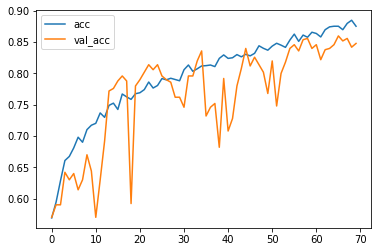

In [33]:
plt.plot(history.epoch, history.history.get('acc'), label='acc')
plt.plot(history.epoch, history.history.get('val_acc'), label='val_acc')
plt.legend()

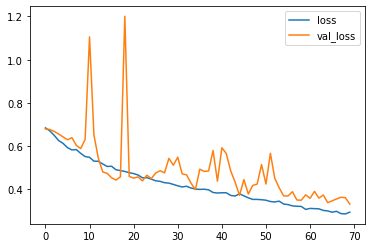

In [34]:
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()

In [35]:
pred=model.predict(test_data)

In [36]:
pred_=[int(i>0.5) for i in pred]

In [37]:
from  sklearn.metrics import classification_report

In [38]:
print(classification_report(test_label_ds,pred_))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       195
           1       0.86      0.84      0.85       248

    accuracy                           0.83       443
   macro avg       0.83      0.83      0.83       443
weighted avg       0.83      0.83      0.83       443

